In [1]:
import matplotlib.pyplot as plt
import librosa
import numpy as np
import torchaudio
import torch
import torch.nn as nn
import torch.optim as optim
import math
import time
import os

In [2]:
# Set input_song to path of your song
####################################
input_song = 'My_Voice (1).mp3'
####################################

# Output location
output_file = 'reconstructed_audio.wav'

In [3]:
# Short time fourier transform hyper parameters:
n_fft = 20000
hop_length = math.floor(n_fft / 4) # set to PyTorch documentation default

# Training options
train = False
transfer_learning = True
save_model = True

epoch_num = 1000 # training iterations

# Path to training data assuming it uses structure:
#       training_data_path
#               ^
#             song_1
#               ^    
# clean_song_1.wav, dirty_song_1.wav
training_data_path = "training_data"

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
# Loads individual audio files into tensors
def file_loader(audio_file):
    # Loads input audio file
    output, sample_rate = torchaudio.load(audio_file)
    
    # Turn tensor into displayable form using Short-Time Fourier Transform
    stft_result = torch.stft(output, n_fft=n_fft, hop_length=hop_length, return_complex=True)

    # Seperate phase information from the complex number output of STFT
    phase = torch.angle(stft_result)
    
    # Seperate magnitude information from the complex number output of STFT
    magnitude = torch.abs(stft_result)
    db_magnitude = librosa.amplitude_to_db(magnitude.numpy())

    return torch.tensor(db_magnitude), torch.tensor(phase), sample_rate

In [6]:
# Function loads training songs in a folder into arrays of dirty tensors
# and clean tensors

# Assumes file structure of:
#          source_path
#               ^
#             song_1
#               ^    
# clean_song_1.wav, dirty_song_1.wav

def data_loader(source_path):
    dirty_data_arr = []
    clean_data_arr = []

    folder_list = os.listdir(source_path)

    for folder in folder_list:
        folder_path = os.path.join(source_path, folder)
        file_list = os.listdir(folder_path)
        
        for file in file_list:
            file_relative_path = os.path.join(folder_path, file)
            
            magnitude, phase, _ = file_loader(file_relative_path)

            if "clean_data" in file:
                clean_data_arr.append(magnitude.to(device))
            else:
                dirty_data_arr.append(magnitude.to(device))
                
                
    return dirty_data_arr, clean_data_arr

In [7]:
# 
def plot_spectrogram(waveform, sample_rate, hop_length, y_axis="linear"):
    waveform = waveform.cpu().numpy()
    
    plt.figure(figsize=(25, 10))
    librosa.display.specshow(waveform, 
                             sr=sample_rate, 
                             hop_length=hop_length, 
                             x_axis="time", 
                             y_axis=y_axis)
    plt.colorbar(format="%+2.f")

In [8]:
class CNNNoiseReducer(nn.Module):
    def __init__(self):
        super(CNNNoiseReducer, self).__init__()
        
        # Encoder takes in left/right audio channels as input,
        # applies 60 filters outputting a channel per filter
        # while compressing each channel based on the kernal size
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=2, out_channels=60, kernel_size=3, padding=0, bias=True),
            nn.ReLU(),
            nn.Conv2d(in_channels=60, out_channels=60, kernel_size=3, padding=0, bias=True),
            nn.ReLU(),
            nn.Conv2d(in_channels=60, out_channels=60, kernel_size=3, padding=0, bias=True),
            nn.ReLU()
        )
        
        # Decoder performs actions of encoder but vice-versa
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(in_channels=60, out_channels=60, kernel_size=3, padding=0, bias=True),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=60, out_channels=60, kernel_size=3, padding=0, bias=True),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=60, out_channels=2, kernel_size=3, padding=0, bias=True) 
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [9]:
def CNN_trainer(model, dirty_data_arr, clean_data_arr, epoch_num):
    # Loss function
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.00005)

    # Early stop parameters
    patience = 4000  # Number of epochs to wait without loss improvement
    best_loss = float('inf')
    epochs_without_improvement = 0

    # Training loop
    for epoch in range(epoch_num):
        mean_loss = 0
        
        for i in range(len(dirty_data_arr)):
            optimizer.zero_grad()

            # Forward pass
            output_package = model(dirty_data_arr[i].unsqueeze(0))  # Adding batch dimension

            # Compute loss
            loss = criterion(output_package, clean_data_arr[i].unsqueeze(0))  # Adding batch dimension
            mean_loss += loss.item()
            
            # Backpropagation
            loss.backward()
            optimizer.step()
        
        mean_loss /= len(dirty_data_arr) # get average loss for the epoch

        print(f"Epoch [{epoch+1}/{epoch_num}], Loss: {mean_loss:.4f}") #:.4f displays 4 decimals

        # Check for early stopping
        if mean_loss < best_loss:
            best_loss = mean_loss
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1
            if epochs_without_improvement >= patience:
                print("Early stop: Loss stagnated")
                break  # Stop training

    print("Training complete")
    
    return model

In [10]:
# Takes a model and song as input and saves the resulting audio output
def audio_predictor(model, song_path, output_path):
    model = model.to(device)
    
    # Load song
    magnitude_data, phase_data, sample_rate = file_loader(song_path)
    
    # Make prediction
    magnitude_pred = model(magnitude_data.to(device))
    magnitude_pred = magnitude_pred.cpu()

    plot_spectrogram(magnitude_pred[0].detach(), sample_rate, hop_length, y_axis="linear")
    
    amplitude_magnitude_pred = librosa.db_to_amplitude(magnitude_pred.detach().numpy())

    final_audio = torch.istft(torch.tensor(amplitude_magnitude_pred * np.exp(1j * phase_data.detach().numpy())), hop_length=hop_length, n_fft=n_fft)
    
    # Save file
    torchaudio.save(output_file, final_audio, sample_rate)
    
    return magnitude_pred.to(device), phase_data

In [11]:
if train:
    dirty_data_arr, clean_data_arr = data_loader(training_data_path)

    ############################
    start = time.time()
    print("Timer Started")
    ############################

    model = CNNNoiseReducer()
    
    if transfer_learning:
        model.load_state_dict(torch.load('cnn_autoencoder.pth'))
    
    model = model.to(device)
    
    model = CNN_trainer(model, dirty_data_arr, clean_data_arr, epoch_num)

    ############################
    end = time.time()
    time_elapsed = end - start
    print(f"Time Elapsed: {time_elapsed}")
    ############################
    
    if save_model:
        torch.save(model.state_dict(), 'cnn_autoencoder.pth')

In [12]:
# Load trained model
model_loaded = CNNNoiseReducer()

model_loaded.load_state_dict(torch.load('cnn_autoencoder.pth'))
model_loaded = model_loaded.eval() 

C:\Users\yairz\AppData\Local\Temp\ipykernel_28944\375750885.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(db_magnitude), torch.tensor(phase), sample_rate


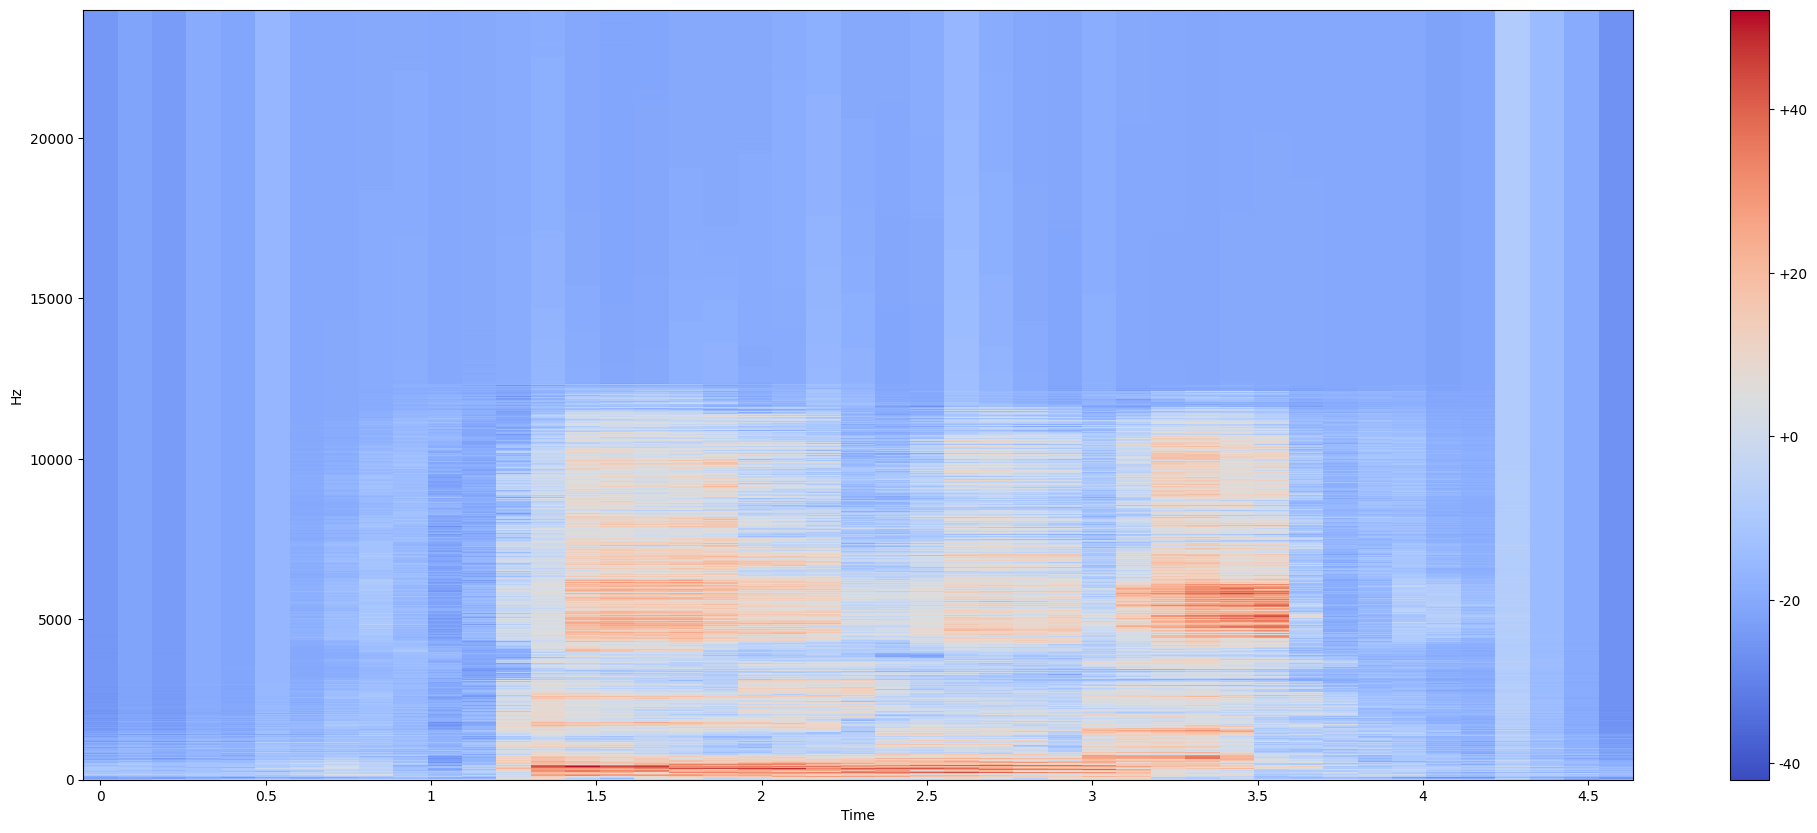

In [13]:
_, _ = audio_predictor(model_loaded, input_song, output_file)